<a href="https://colab.research.google.com/github/joaomottin/DataScienceLab/blob/main/GraficoSpam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
from google.colab import files
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

uploaded = files.upload()


Saving SMSSpamCollection to SMSSpamCollection


In [17]:
df = pd.read_csv(io.BytesIO(uploaded['SMSSpamCollection']),sep = '\t')
print(df)

     target                                               text
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham               Will ü b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

[5572 rows x 2 columns]


In [18]:
#Mostra a quantidade de linhas e colunas
df.shape

(5572, 2)

In [19]:
df['target'] = df['target'].apply(lambda x: 0 if x == 'ham' else 1)  # converte 'ham' para 0 e 'spam' para 1

In [20]:
df.groupby('target')['target'].count()

,target
target,
0,4825
1,747


In [21]:
print("\nVerificando balanceamento:")
contagem_classes = df.groupby('target')['target'].count()
total = contagem_classes.sum()
porcentagem_classes = contagem_classes / total * 100
print(porcentagem_classes)


# Separamos os dados para treino e test
from sklearn.model_selection import train_test_split
X = df['text']
y = df['target']

#Embaralhamos os dados sendo 25% para teste e 75% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nTamanho do Treino: {len(X_train)} amostras")
print(f"Tamanho do Teste: {len(X_test)} amostras")


Verificando balanceamento:
target
0    86.593683
1    13.406317
Name: target, dtype: float64

Tamanho do Treino: 4179 amostras
Tamanho do Teste: 1393 amostras


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Baixa uma lista de palavras que não tem peso para frases (stopwords)
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Inicializa o vetorizador
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Aprende o vocabulário e transforma os dados de TREINO
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apenas transforma os dados de TESTE (usando o vocabulário do treino)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nShape da matriz TF-IDF (Treino): {X_train_tfidf.shape}")


Shape da matriz TF-IDF (Treino): (4179, 7355)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# --- 4. OTIMIZAÇÃO DE HIPERPARÂMETROS (Grid Search) (Item v) ---

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

print("\n--- Iniciando Otimização (Grid Search) ---")

# --- 4.1 Otimização para RandomForest ---
print("Iniciando Grid Search para RandomForest...")

# Define os parâmetros que queremos testar
param_grid_rf = {
    'n_estimators': [100, 200],         # Número de árvores
    'max_depth': [None, 30],            # Profundidade máxima
    'min_samples_leaf': [1, 2]          # Mínimo de amostras por folha
}

# Cria o objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # 3-fold cross-validation (mais rápido)
                              n_jobs=-1, # Usar todos os processadores
                              scoring='f1') # Otimizar pelo F1-score

# Executa a busca nos dados de treino
grid_search_rf.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de RandomForest encontrado
model = grid_search_rf.best_estimator_

print(f"Melhores parâmetros para RandomForest: {grid_search_rf.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_rf.best_score_:.4f}")


# --- 4.2 Otimização para Regressão Logística ---
print("\nIniciando Grid Search para Regressão Logística...")

# Define os parâmetros para testar
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],           # Força da regularização
    'solver': ['liblinear', 'saga'],  # Algoritmos de otimização
    'penalty': ['l1', 'l2']           # Tipo de regularização
}

# Cria o objeto GridSearchCV
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                              param_grid=param_grid_lr,
                              cv=3,
                              n_jobs=-1,
                              scoring='f1')

# Executa a busca nos dados de treino
grid_search_lr.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de Regressão Logística encontrado
lr_model = grid_search_lr.best_estimator_

print(f"Melhores parâmetros para Regressão Logística: {grid_search_lr.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_lr.best_score_:.4f}")


--- Iniciando Otimização (Grid Search) ---
Iniciando Grid Search para RandomForest...
Melhores parâmetros para RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}
Melhor F1-score (validação): 0.8874

Iniciando Grid Search para Regressão Logística...
Melhores parâmetros para Regressão Logística: {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
Melhor F1-score (validação): 0.8881


In [24]:
# --- 5. AVALIAÇÃO DOS MODELOS OTIMIZADOS (Item vi) ---

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)

print("\n--- Avaliação de Performance dos Modelos Otimizados ---")

# --- 5.1 Previsões (com os modelos otimizados) ---

# RandomForest
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo (classe 1)

# Regressão Logística
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo

# --- 5.2 Cálculo das Métricas ---

# Métricas para o RandomForest
print("\nRandom Forest (Otimizado):")
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_auc_roc = roc_auc_score(y_test, y_pred_proba)
rf_auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Acurácia: {rf_accuracy:.4f}")
print(f"Precisão: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc_roc:.4f}")
print(f"AUC-PR (AP): {rf_auc_pr:.4f}")

# Métricas para a Regressão Logística
print("\nRegressão Logística (Otimizada):")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc_roc = roc_auc_score(y_test, y_pred_proba_lr)
lr_auc_pr = average_precision_score(y_test, y_pred_proba_lr)

print(f"Acurácia: {lr_accuracy:.4f}")
print(f"Precisão: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"AUC-ROC: {lr_auc_roc:.4f}")
print(f"AUC-PR (AP): {lr_auc_pr:.4f}")


--- Avaliação de Performance dos Modelos Otimizados ---

Random Forest (Otimizado):
Acurácia: 0.9763
Precisão: 1.0000
Recall: 0.8226
F1-Score: 0.9027
AUC-ROC: 0.9967
AUC-PR (AP): 0.9868

Regressão Logística (Otimizada):
Acurácia: 0.9842
Precisão: 0.9940
Recall: 0.8871
F1-Score: 0.9375
AUC-ROC: 0.9930
AUC-PR (AP): 0.9825



Plotando curvas de avaliação com pontos de corte ótimos...


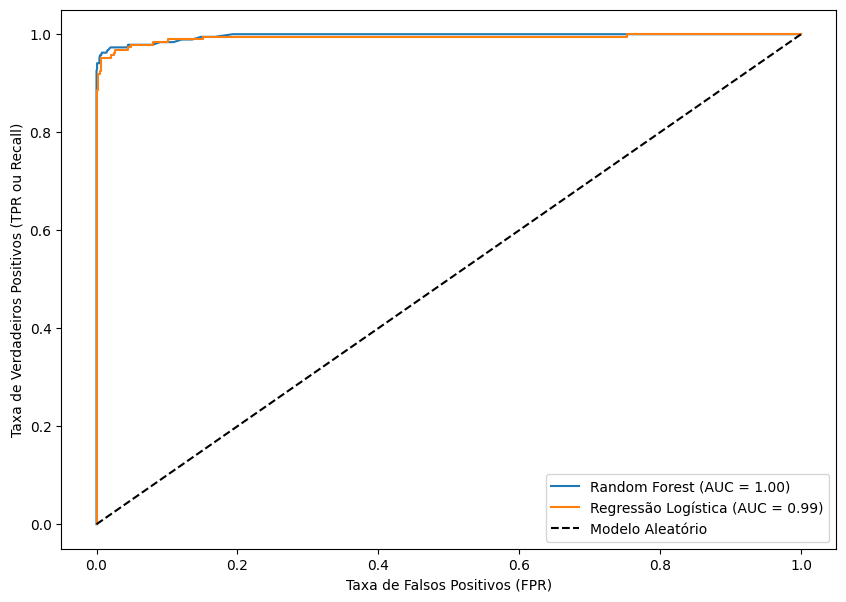

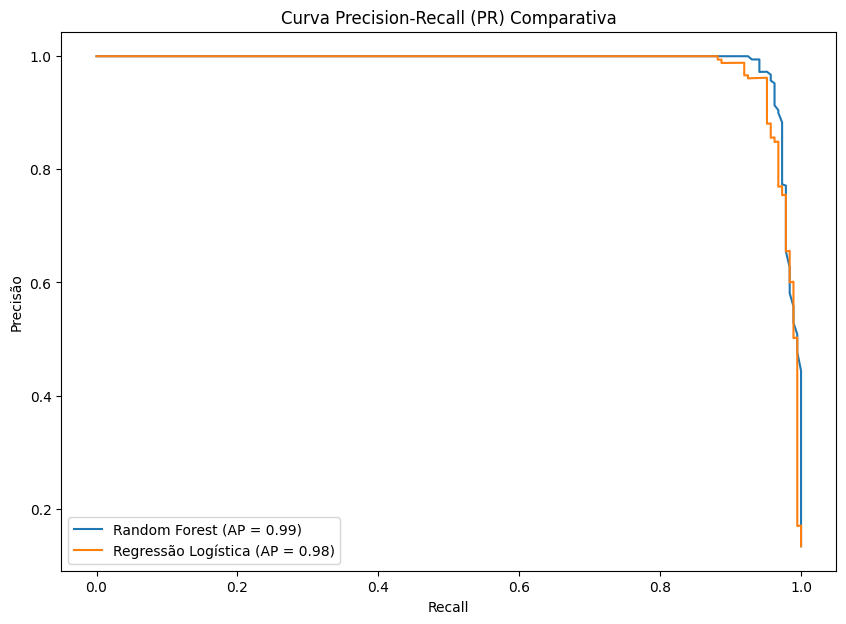

In [25]:
# --- 5.3 Plotar Curvas ROC e PR (COM PONTO DE CORTE ÓTIMO) ---

print("\nPlotando curvas de avaliação com pontos de corte ótimos...")

# --- Curva ROC ---

# 1. Calcular dados para RandomForest (agora salvando os 'thresholds_rf')
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba)


# 2. Calcular dados para Regressão Logística (salvando 'thresholds_lr')
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

# 3. Plotar o gráfico ROC com os pontos
plt.figure(figsize=(10, 7))
# Plot das curvas
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc_roc:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {lr_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório') # Linha de referência


plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.show()


# --- Curva PR (Precision-Recall) ---
# (Este código continua o mesmo de antes, mas está incluído para facilitar a cópia)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {rf_auc_pr:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Regressão Logística (AP = {lr_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (PR) Comparativa')
plt.legend()
plt.show()


--- Análise de Pontos de Corte (Usando RandomForest) ---


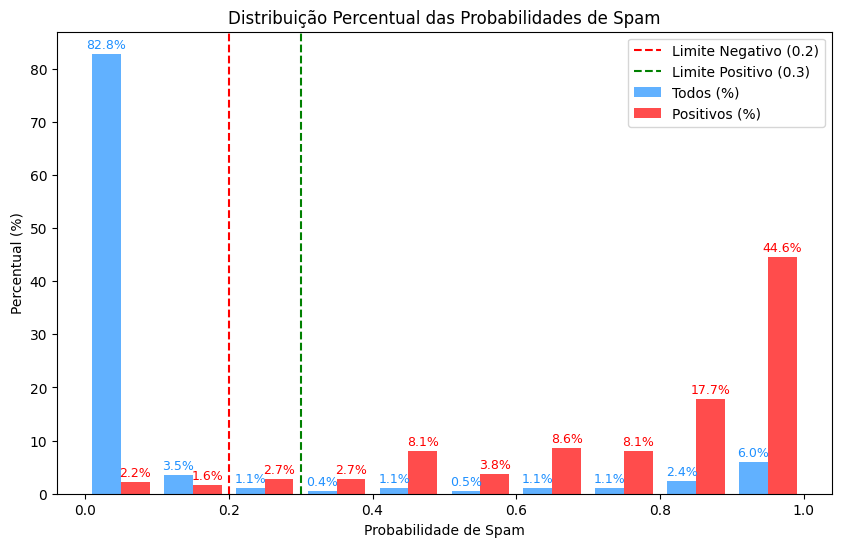

Avaliando métricas para os cortes 0.2 e 0.3...

Corte 0.2
Accuracy: 0.9885139985642498
Precision: 0.9521276595744681
Recall: 0.9623655913978495
F1: 0.9572192513368984

Corte 0.3
Accuracy: 0.9913854989231874
Precision: 0.9943181818181818
Recall: 0.9408602150537635
F1: 0.9668508287292817

Divisão por Zonas (Negativa / Manual / Positiva):
zone
negativa    86.503948
positiva    12.634602
manual       0.861450
Name: proportion, dtype: float64


In [28]:
# --- 6. ANÁLISE DE PONTOS DE CORTE (Item vii) ---
# (Usando o melhor modelo. Vamos assumir que foi o RandomForest 'model')

print("\n--- Análise de Pontos de Corte (Usando RandomForest) ---")

#Pega as probabilidades de ser positivo
positive_probs = y_pred_proba # Já calculamos isso antes

#Organiza todas as probabilidades de ser positivo junto do target (y_test)
df_pos = pd.DataFrame({"prob_spam": positive_probs, "target": y_test.values})

#Separa apenas para os que são positivos
df_apenas_positivo = df_pos.loc[df_pos['target']==1]

#Cria as caixas (bins) de 10% em 10% porcento
step = 0.1
bins = np.arange(0, 1 + step, step)

#Faz a contagem de todas as probabilidades
hist_all, _ = np.histogram(df_pos["prob_spam"], bins=bins)
#Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos, _ = np.histogram(df_apenas_positivo["prob_spam"], bins=bins)

# Convertendo para percentual (%)
# (Adicionado .sum() para evitar divisão por zero se um bin estiver vazio)
hist_all_pct = (hist_all / (hist_all.sum() + 1e-9)) * 100
hist_pos_pct = (hist_pos / (hist_pos.sum() + 1e-9)) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', color='red', alpha=0.7)

for xi, val_all, val_pos in zip(x, hist_all_pct, hist_pos_pct):
    # Texto da população total (azul)
    plt.text(xi - width/2, val_all + 0.5, f"{val_all:.1f}%", ha='center', va='bottom', fontsize=9, color='#1E90FF')
    # Texto dos positivos (vermelho)
    plt.text(xi + width/2, val_pos + 0.5, f"{val_pos:.1f}%", ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam')

# Pontos de corte customizáveis
threshold_neg = 0.2
threshold_pos = 0.3
plt.axvline(threshold_neg, color='red', linestyle='--', label=f'Limite Negativo ({threshold_neg})')
plt.axvline(threshold_pos, color='green', linestyle='--', label=f'Limite Positivo ({threshold_pos})')

plt.legend()
plt.show()

# --- 6.1 Métricas para os pontos de corte ---
print(f"Avaliando métricas para os cortes {threshold_neg} e {threshold_pos}...")

# Corte 0.2 -> considera como positivo apenas prob > 0.2
y_pred_02 = (df_pos["prob_spam"] > threshold_neg).astype(int)

# Corte 0.4 -> considera como positivo prob >= 0.4
y_pred_04 = (df_pos["prob_spam"] >= threshold_pos).astype(int)

# métricas para corte 0.4
print(f"\nCorte {threshold_neg}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_02))
print("Precision:", precision_score(df_pos["target"], y_pred_02))
print("Recall:", recall_score(df_pos["target"], y_pred_02))
print("F1:", f1_score(df_pos["target"], y_pred_02))

# métricas para corte 0.7
print(f"\nCorte {threshold_pos}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_04))
print("Precision:", precision_score(df_pos["target"], y_pred_04))
print("Recall:", recall_score(df_pos["target"], y_pred_04))
print("F1:", f1_score(df_pos["target"], y_pred_04))

# --- 6.2 Divisão em Zonas ---
def assign_zone(prob):
    if prob <= threshold_neg:
        return "negativa"
    elif prob >= threshold_pos:
        return "positiva"
    else:
        return "manual"

#Usa a função para cada uma das probabilidades
df_pos["zone"] = df_pos["prob_spam"].apply(assign_zone)

# Ver quantos exemplos vão para cada zona
print("\nDivisão por Zonas (Negativa / Manual / Positiva):")
print(df_pos["zone"].value_counts(normalize=True) * 100)


--- Análise de Pontos de Corte (Usando Regressão Logística) ---


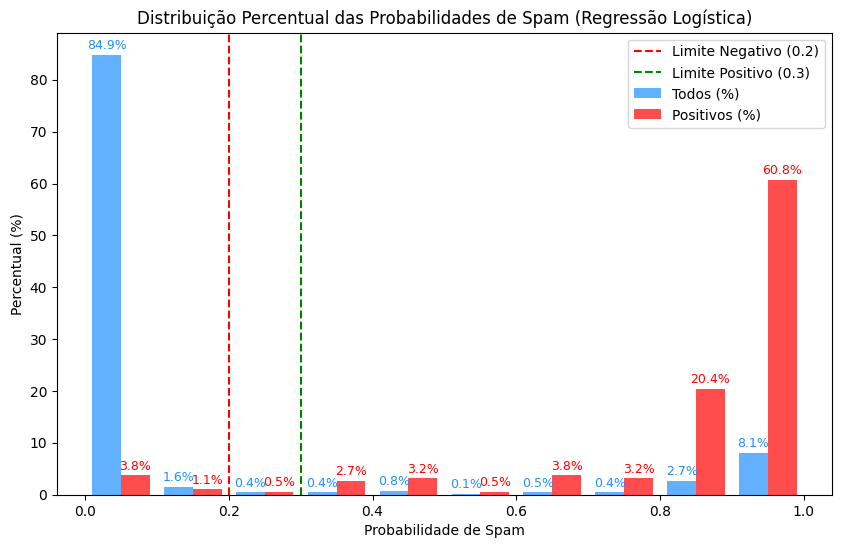

Avaliando métricas para os cortes 0.2 e 0.3...

Corte 0.2
Accuracy: 0.9849246231155779
Precision: 0.9365079365079365
Recall: 0.9516129032258065
F1: 0.944

Corte 0.3
Accuracy: 0.9877961234745154
Precision: 0.9617486338797814
Recall: 0.946236559139785
F1: 0.9539295392953929

Divisão por Zonas (Negativa / Manual / Positiva):
zone
negativa    86.432161
positiva    13.137114
manual       0.430725
Name: proportion, dtype: float64


In [30]:
# --- 6. ANÁLISE DE PONTOS DE CORTE (Usando Regressão Logística) ---

print("\n--- Análise de Pontos de Corte (Usando Regressão Logística) ---")

# Pega as probabilidades de ser positivo
positive_probs_lr = y_pred_proba_lr  # já calculadas acima

# Organiza todas as probabilidades de ser positivo junto do target
df_pos_lr = pd.DataFrame({"prob_spam": positive_probs_lr, "target": y_test.values})

# Separa apenas os que são realmente positivos
df_apenas_positivo_lr = df_pos_lr.loc[df_pos_lr['target'] == 1]

# Cria as caixas (bins) de 10% em 10%
step = 0.1
bins = np.arange(0, 1 + step, step)

# Faz a contagem de todas as probabilidades
hist_all_lr, _ = np.histogram(df_pos_lr["prob_spam"], bins=bins)
# Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos_lr, _ = np.histogram(df_apenas_positivo_lr["prob_spam"], bins=bins)

# Convertendo para percentual (%)
hist_all_pct_lr = (hist_all_lr / (hist_all_lr.sum() + 1e-9)) * 100
hist_pos_pct_lr = (hist_pos_lr / (hist_pos_lr.sum() + 1e-9)) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hist_all_pct_lr, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct_lr, width=width, label='Positivos (%)', color='red', alpha=0.7)

# Adiciona o percentual acima das barras (ambos)
for xi, val_all, val_pos in zip(x, hist_all_pct_lr, hist_pos_pct_lr):
    plt.text(xi - width/2, val_all + 0.5, f"{val_all:.1f}%", ha='center', va='bottom', fontsize=9, color='#1E90FF')
    plt.text(xi + width/2, val_pos + 0.5, f"{val_pos:.1f}%", ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam (Regressão Logística)')

# Pontos de corte customizáveis (mesmos do RandomForest)
threshold_neg = 0.2
threshold_pos = 0.3
plt.axvline(threshold_neg, color='red', linestyle='--', label=f'Limite Negativo ({threshold_neg})')
plt.axvline(threshold_pos, color='green', linestyle='--', label=f'Limite Positivo ({threshold_pos})')

plt.legend()
plt.show()

# --- 6.1 Métricas para os pontos de corte ---
print(f"Avaliando métricas para os cortes {threshold_neg} e {threshold_pos}...")

# Corte 0.4
y_pred_04_lr = (df_pos_lr["prob_spam"] > threshold_neg).astype(int)
# Corte 0.7
y_pred_07_lr = (df_pos_lr["prob_spam"] >= threshold_pos).astype(int)

# Métricas para corte 0.4
print(f"\nCorte {threshold_neg}")
print("Accuracy:", accuracy_score(df_pos_lr["target"], y_pred_04_lr))
print("Precision:", precision_score(df_pos_lr["target"], y_pred_04_lr))
print("Recall:", recall_score(df_pos_lr["target"], y_pred_04_lr))
print("F1:", f1_score(df_pos_lr["target"], y_pred_04_lr))

# Métricas para corte 0.7
print(f"\nCorte {threshold_pos}")
print("Accuracy:", accuracy_score(df_pos_lr["target"], y_pred_07_lr))
print("Precision:", precision_score(df_pos_lr["target"], y_pred_07_lr))
print("Recall:", recall_score(df_pos_lr["target"], y_pred_07_lr))
print("F1:", f1_score(df_pos_lr["target"], y_pred_07_lr))

# --- 6.2 Divisão em Zonas ---
def assign_zone_lr(prob):
    if prob <= threshold_neg:
        return "negativa"
    elif prob >= threshold_pos:
        return "positiva"
    else:
        return "manual"

# Usa a função para cada uma das probabilidades
df_pos_lr["zone"] = df_pos_lr["prob_spam"].apply(assign_zone_lr)

# Ver quantos exemplos vão para cada zona
print("\nDivisão por Zonas (Negativa / Manual / Positiva):")
print(df_pos_lr["zone"].value_counts(normalize=True) * 100)



--- Top 10 Palavras Mais Importantes (RandomForest) ---
     Palavra  Importancia
1525    call     0.039549
6740     txt     0.025907
1732   claim     0.022165
7257     www     0.021857
2832    free     0.020004
4317  mobile     0.019837
6766      uk     0.018343
5157   prize     0.014036
293     150p     0.013113
6187    stop     0.013020


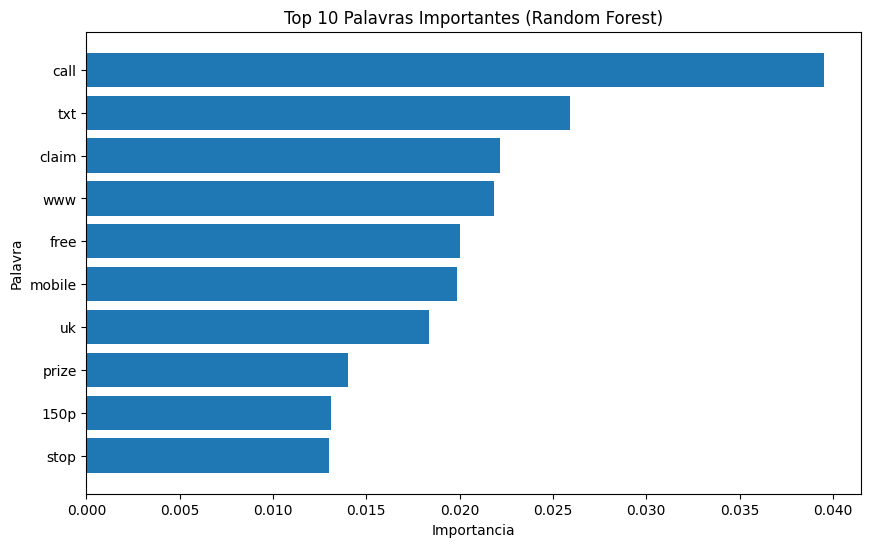

In [31]:
# --- 7. IMPORTÂNCIA DAS FEATURES (PALAVRAS) ---
# (Usando o RandomForest, que tem 'feature_importances_')

print("\n--- Top 10 Palavras Mais Importantes (RandomForest) ---")

#Pega a importancia de cada palavra
importances = model.feature_importances_
#Pega a lista de palavras na mesma ordem
feature_names = vectorizer.get_feature_names_out()

#Cria um dataframe com as palavras e suas notas
feature_importance_df = pd.DataFrame({'Palavra': feature_names, 'Importancia': importances})

#Ordena a tabela pela Importancia
feature_importance_df = feature_importance_df.sort_values('Importancia', ascending=False)

#Quantidade de palavras que queremos
N = 10
print(feature_importance_df.head(N))

#Desenha o gráfico
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Palavra'][:N], feature_importance_df['Importancia'][:N])
plt.xlabel('Importancia')
plt.ylabel('Palavra')
plt.title(f'Top {N} Palavras Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.show()